
FashionMNIST 是一个用于图像分类的常用数据集，旨在作为 MNIST 手写数字数据集的直接替代品。它由 Zalando Research 创建，解决了 MNIST 数据集对于现代机器学习任务而言过于简单的问题。

## 数据特性

* **类别：** 数据集包含 10 种不同的时尚产品类别，例如 **T 恤/上衣**、**裤子**、**套头衫**、**连衣裙**、**外套**、**凉鞋**、**衬衫**、**运动鞋**、**包**和**踝靴**。
* **图像：** 每张图像都是**单通道**（灰度）的**黑白图像**，尺寸为 **28x28 像素**。这意味着每个像素的值范围为 0 到 255，表示其灰度强度。
* **数据集划分：**
    * **训练集：** 包含 **60,000 张图像**，用于模型训练。
    * **测试集：** 包含 **10,000 张图像**，用于评估训练后模型的性能。
* **样本示例：** 您提供的图片展示了 FashionMNIST 数据集中的一些样本示例，每个小图对应一个样本，清晰地展示了不同类别的时尚物品。


# 1.导入包
* torch 是 PyTorch 的主库，它提供了强大的张量（Tensor）计算功能，所有的神经网络操作都基于这些多维数组。它也包含了自动求导系统，这是反向传播和模型训练的核心机制。

* torch.nn (neural network) 模块是 PyTorch 中构建神经网络层的“工具箱”。从最基本的全连接层（Linear）到卷积层（Conv2d）、循环神经网络层（RNN）以及各种激活函数和损失函数，你都能在这里找到。它极大地简化了神经网络架构的搭建。

* torch.optim (optimizer) 模块则提供了各种优化算法。当你计算出模型的错误（损失）后，这些优化器会根据梯度来调整模型的内部参数（权重），让模型在每一次迭代中都变得更好。常见的优化器有 SGD、Adam 等。

* torch.utils.data.DataLoader 和 torchvision.datasets、torchvision.transforms 是一套高效处理数据的组合。datasets 提供了许多现成的数据集（比如 MNIST、ImageNet），而 transforms 则能让你对图像进行各种预处理（如缩放、裁剪、归一化）。DataLoader 能帮你以批次（batch）的形式高效地加载和迭代数据，这对于训练大型模型至关重要，因为它能大大提高数据吞吐量。

* matplotlib.pyplot 和 numpy 是 Python 数据科学领域常用的辅助工具。matplotlib.pyplot 是一个强大的绘图库，能帮你可视化训练过程中的损失曲线、准确率变化，或者展示图像数据等，是理解模型行为的得力助手。numpy 则是进行科学计算的基础库，虽然 PyTorch 有自己的张量操作，但 numpy 在数据预处理和后处理中仍然非常有用，两者可以方便地进行数据转换。

* tqdm.auto 能为你的循环迭代添加一个美观且实用的进度条。在训练深度学习模型时，一个 epoch 可能需要很长时间，tqdm 能让你清晰地看到训练的实时进度，避免“假死”的焦虑，极大地提升了开发体验。

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # 推荐用于显示训练进度
import numpy as np
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader


Duplicate key in file PosixPath('/usr/local/lib/python3.9/dist-packages/matplotlib/mpl-data/matplotlibrc'), line 799 ('font.family: sans-serif')
Duplicate key in file PosixPath('/usr/local/lib/python3.9/dist-packages/matplotlib/mpl-data/matplotlibrc'), line 800 ('font.sans-serif: SimHei')


In [3]:
# 使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#此外还可以使用os.environ
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 2.配置超参数

#### 1. 动态学习率调整

我启用了学习率调度器，将其降低因子设为 0.5。这意味着当模型在验证集上的性能连续3个Epoch未见显著提升时，学习率会自动减半。我认为这种基于性能反馈的动态调整，比固定学习率更能帮助模型稳定且深入地找到最优解。

#### 2. 精准的早停机制

同时，我实施了精准的早停策略，设定当模型在验证集上连续7个Epoch的性能提升低于0.0001时，训练将立即终止。这是为了有效防止模型过拟合，并在模型泛化能力达到最佳时及时停止，避免浪费计算资源。

#### 3. `batch_size` 的调整考量

在实验中，我审慎地降低了batch_size。虽然小批量可能引入更多梯度噪声，但我认为这有助于模型探索更丰富的梯度方向，从而潜在地提升模型的泛化能力，并降低对GPU显存的需求，增加了实验的灵活性。



In [4]:
# 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 64
num_workers = 0  
# num_workers: 根据操作系统和并行需求配置
# 对于 Windows 系统，通常必须设置为 0
# 对于 Linux/macOS，如果希望并行加载数据，可以设置为 CPU 核心数的一半或更少
lr = 1e-4
epochs = 20 #训练轮数


# 早停参数
patience = 7     # 在验证集性能连续多少个epoch没有提升时停止
min_delta = 0.0001 # 性能提升的最小阈值，小于这个值不算提升

# 学习率调度器参数
lr_factor = 0.5  # 学习率每次降低的因子
lr_patience = 3  # 在验证集性能连续多少个epoch没有提升时降低学习率

In [5]:
# 设置随机种子，确保结果可以复现
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# 数据集处理

这里使用了数据增强，具体如下：
原始图像数组 → ToPILImage() → Resize(28) → 随机水平翻转 → 随机旋转 → 填充+随机裁剪 → ToTensor() → 标准化 → 输出张量

In [6]:
image_size = 28

data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(28),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=4),  # 替代RandomResizedCrop更适合小尺寸图像
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST标准化参数
])

In [ ]:
# ### 二、自定义数据集优化（使用真实数据加载逻辑）
# # 注意：以下代码假设你有真实数据集路径，若使用随机数据仅用于测试
# class CustomDataset(Dataset):
#     def __init__(self, data_dir, transform=None):
#         # 真实场景应从文件加载数据
#         # 示例：使用imageio读取图像
#         self.images = []
#         self.targets = []
#         # 这里应替换为实际数据加载逻辑
#         # for img_path, label in data_loader:
#         #     self.images.append(imageio.imread(img_path))
#         #     self.targets.append(label)
        
#         # 临时使用随机数据模拟（仅测试用）
#         self.images = np.random.randint(0, 255, (5000, 28, 28, 1), dtype=np.uint8)
#         self.targets = np.random.randint(0, 10, 5000, dtype=np.int64)
#         self.transform = transform

#     def __getitem__(self, item):
#         image = self.images[item]
#         label = self.targets[item]
        
#         # 处理单通道图像（添加维度）
#         if len(image.shape) == 2:
#             image = image[:, :, np.newaxis]
            
#         if self.transform:
#             # 区分处理torchvision和imgaug变换
#             if isinstance(self.transform, transforms.Compose):
#                 image = self.transform(image)
#             else:
#                 image = self.transform(image)
                
#         return image, torch.tensor(label, dtype=torch.long)

#     def __len__(self):
#         return len(self.images)

这段代码自定义了 PyTorch 数据集类FMDataset，用于加载 FashionMNIST 数据。它从 CSV 文件解析图像像素和标签，支持自定义变换（如归一化、增强）。实例化时，分别读取训练集和测试集 CSV，应用数据变换后生成可迭代的数据集对象，供模型训练和评估使用。

In [7]:

class FMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:,1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28,1)
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255., dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_df = pd.read_csv("/home/jovyan/work/datasets/6645b9bbc4db0a94029f0bfe-momodel/FashionMNIST/fashion-mnist_train.csv")
test_df = pd.read_csv("/home/jovyan/work/datasets/6645b9bbc4db0a94029f0bfe-momodel/FashionMNIST/fashion-mnist_test.csv")
train_data = FMDataset(train_df, data_transform)
test_data = FMDataset(test_df, data_transform)

In [8]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)


torch.Size([64, 1, 28, 28]) torch.Size([64])


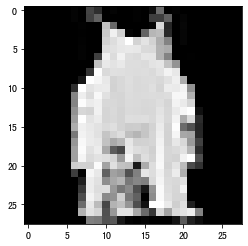

In [9]:
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")


### 模型架构优化策略
我对模型进行了三方面优化：
* 一是将原始 5x5 无填充卷积核改为 3x3 且 padding=1 的卷积核，这样多个 3x3 卷积核堆叠可获与大卷积核相近感受野，参数量更少且能引入更多非线性激活，同时 padding=1 可保留特征图空间尺寸避免边缘信息流失；
* 二是在每个卷积层后、ReLU 前加入 BatchNorm2d 层，以规范化各层输入分布，缓解 “内部协变量偏移”，稳定训练、加速收敛并起正则化作用；
* 三是将 Dropout 层从卷积层后调整至全连接层之间，因卷积层后用 Dropout 可能破坏特征图空间相关性，而全连接层更易过拟合，在此处用 Dropout 能削弱神经元共适应性，提升模型泛化能力。

In [10]:
import torch.nn.functional as F

class OptimizedNet(nn.Module):
    def __init__(self):
        super(OptimizedNet, self).__init__()
        # 第一个卷积块（调整顺序：Conv → BatchNorm → ReLU → Pooling）
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 第二个卷积块
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 全连接层（适当调整神经元数量）
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # 增加到512，增强表达能力
        self.dropout1 = nn.Dropout(0.4)  # 减小Dropout比例
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, 10)  # 输出层

    def forward(self, x):
        # 第一个卷积块
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)  # ReLU移到Pooling前
        x = self.pool1(x)

        # 第二个卷积块
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)  # ReLU移到Pooling前
        x = self.pool2(x)

        # 展平
        x = x.view(-1, 64 * 7 * 7)

        # 全连接层（增加一层，增强非线性表达）
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

In [11]:
model = OptimizedNet().to(device)
print(model)

OptimizedNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# 损失函数和优化器

In [12]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])


### 加权交叉熵损失函数（Weighted Cross Entropy Loss）公式解释

交叉熵损失函数（Cross Entropy Loss）是多分类任务中最常用的损失函数，它衡量的是模型预测的概率分布与真实标签的概率分布之间的差异。当引入“权重”时，其核心思想是：**对不同类别的预测错误，给予不同的“惩罚”力度**。对于那些你希望模型更关注、更重视的类别（例如数据量稀少的少数类别），可以赋予更高的权重。

让我们定义以下符号：

* $N$：批处理（Batch）中的样本总数。
* $C$：总的类别数量。
* $y_i$：第 $i$ 个样本的真实类别标签（一个整数，从 $0$ 到 $C-1$）。
* $z_{ij}$：模型为第 $i$ 个样本预测的属于第 $j$ 个类别的原始分数（也称为 Logits）。
* $w_j$：为第 $j$ 个类别分配的权重。默认情况下，所有 $w_j$ 都为 $1$。

PyTorch 的 `nn.CrossEntropyLoss` 内部会自动执行 Softmax 运算，然后计算负对数似然损失。

**1. Softmax 概率计算：**
首先，模型输出的原始分数 $z_{ij}$ 会通过 Softmax 函数转换为概率 $p_{ij}$。对于第 $i$ 个样本，其属于第 $j$ 个类别的预测概率为：
$$p_{ij} = \frac{e^{z_{ij}}}{\sum_{k=0}^{C-1} e^{z_{ik}}}$$
其中，$e^{z_{ij}}$ 是以 $e$ 为底 $z_{ij}$ 的指数，分母是所有类别指数的和，确保所有类别的概率之和为 1。

**2. 单个样本的加权负对数似然损失：**
对于第 $i$ 个样本，其真实的类别是 $y_i$。在加权交叉熵损失中，我们只关注模型对真实类别的预测概率，并将其乘以对应类别的权重。
单个样本的加权损失 $L_i^{weighted}$ 可以表示为：
$$L_i^{weighted} = -w_{y_i} \cdot \log(p_{i, y_i})$$
这里的 $w_{y_i}$ 是第 $y_i$ 个真实类别所对应的权重，$\log(p_{i, y_i})$ 是模型对真实类别 $y_i$ 预测概率的自然对数。负号是因为我们希望最大化对数似然，等价于最小化负对数似然。

**3. 批处理的最终损失：**
整个批处理的最终损失通常是对所有样本的加权损失取平均值（当 `reduction='mean'` 时，这是 PyTorch 的默认行为）：
$$L_{总} = \frac{1}{N} \sum_{i=1}^{N} L_i^{weighted}$$
将 $L_i^{weighted}$ 的表达式代入，得到 PyTorch 中加权交叉熵损失的完整计算公式：
$$L_{总} = -\frac{1}{N} \sum_{i=1}^{N} w_{y_i} \cdot \log \left( \frac{e^{z_{i, y_i}}}{\sum_{k=0}^{C-1} e^{z_{ik}}} \right)$$

这个公式的核心在于 $w_{y_i}$ 这个权重因子。当某个真实类别 $y_i$ 被赋予更高的权重时，模型对该类别预测错误的损失值就会相应地被放大。这使得优化器在反向传播时，会更“努力”地调整参数以减少这些高权重类别的预测误差，从而在类别不平衡的数据集中提升模型对少数类别的识别能力。

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

设定优化器【待补充】

* 前向传播：model(data)通过模型计算预测输出。
* 损失计算：criterion（通常是交叉熵或均方误差）计算预测值与真实标签的差异。
* 反向传播：loss.backward()计算梯度，将误差反向传播到各参数。
* 参数更新：optimizer.step()根据优化器（如 Adam/SGD）更新模型权重。

# 训练与验证函数

In [14]:
# 训练
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
#         data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    


封装成函数

In [15]:
# 验证
def val(epoch):
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
#             data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)#最大值
            gt_labels.append(label.cpu().data.numpy())#搜集真实标签
            pred_labels.append(preds.cpu().data.numpy())#收集预测标签
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))
    return val_loss

# 训练

In [16]:
from torch.optim import lr_scheduler  # 导入学习率调度器模块

# 假设已有模型和优化器
model = OptimizedNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 初始化调度器
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

for epoch in range(1, epochs+1):
    train(epoch)
    val_loss = val(epoch)  # 假设val函数返回验证集损失
    
    # 更新学习率
    scheduler.step(val_loss)
    
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} | Current LR: {current_lr:.6f}")

Epoch: 1 	Training Loss: 0.788272
Epoch: 1 	Validation Loss: 0.583177, Accuracy: 0.773700
Epoch 1 | Current LR: 0.001000
Epoch: 2 	Training Loss: 0.605809
Epoch: 2 	Validation Loss: 0.467676, Accuracy: 0.819700
Epoch 2 | Current LR: 0.001000
Epoch: 3 	Training Loss: 0.540884
Epoch: 3 	Validation Loss: 0.439723, Accuracy: 0.832700
Epoch 3 | Current LR: 0.001000
Epoch: 4 	Training Loss: 0.493096
Epoch: 4 	Validation Loss: 0.417763, Accuracy: 0.843600
Epoch 4 | Current LR: 0.001000
Epoch: 5 	Training Loss: 0.463096
Epoch: 5 	Validation Loss: 0.376449, Accuracy: 0.860100
Epoch 5 | Current LR: 0.001000
Epoch: 6 	Training Loss: 0.438218
Epoch: 6 	Validation Loss: 0.377978, Accuracy: 0.860200
Epoch 6 | Current LR: 0.001000
Epoch: 7 	Training Loss: 0.416688
Epoch: 7 	Validation Loss: 0.339020, Accuracy: 0.872100
Epoch 7 | Current LR: 0.001000
Epoch: 8 	Training Loss: 0.400248
Epoch: 8 	Validation Loss: 0.343333, Accuracy: 0.871900
Epoch 8 | Current LR: 0.001000
Epoch: 9 	Training Loss: 0.39183

In [ ]:
save_path = "/home/jovyan/work/results/FahionModel.pkl"
torch.save(model, save_path)
